The intention with this study is to look at how detectors with different deadtimes impact the retrievals on cloud edges. I will model cloud edges as sigmoids of different slopes (the intention is that they should approximate a step function). They should be analytically integrable so that the processing is fast. The goal here is to use an oversimplified model of a cloud to help make a decision on detector type to purchase with differing deadtime intervals.

I think I will use the logistic function:
$\lambda(x)=\frac{A}{1+e^{-B(x-C)}}+D$, whose integral form $\Lambda(x)=\frac{A}{B}\ln(e^{Bx}+e^{BC})+Dx+C_2$, where I fit to the parameters $A$, $B$, $C$, and $D$, with constant $C_2$.

In [2]:
import os,sys
import numpy as np
import torch
import matplotlib.pyplot as plt

cwd = os.getcwd()
dirLib = cwd + r'/library'
if dirLib not in sys.path:
    sys.path.append(dirLib)

C:\Users\Grant\anaconda3\envs\arsenl-conda\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
dtype = torch.float64
device = torch.device("cpu")

In [4]:
# import library for simulating Poisson point processes
dirP_str = os.path.join(os.environ['USERPROFILE'], 
                    'OneDrive - UCB-O365',
                    'GitHub',
                    'deadtime-sim-ptv',
                    'python',
                    'library')
if dirP_str not in sys.path:
    sys.path.append(dirP_str)
    
import sim_deadtime_utils as sim

# Generate Simulated Data

In [54]:
# simulation resolution settings
t_sim_min = 0
t_sim_max = 1e-6
dt_sim = 1e-12

tD = 28e-9 # deadtime
Nshot = 25 # number of laser shots
wrap_deadtime = True  # wrap deadtime between shots

laser_pulse_width = 20e-9 # laser pulse width in seconds
A = 5e6 # [Hz] amplitude count rate
B = 5e7  # rise time constant
C = 5e-7  # [s] time shift
D = 1e2  # [Hz] background count rate

In [55]:
# generate the simulated scene time axis
t_sim = np.arange(t_sim_min,t_sim_max,dt_sim)           # simulation time
t_sim_bins = np.concatenate((t_sim,t_sim[-1:]+dt_sim))  # simulation time histogram bins

In [56]:
# generate the photon arrival rate of the profile
# Gaussian target with constant background
# photon_rate_arr = target_amplitude*np.exp(-(t_sim - target_time)**2/(2*laser_pulse_width**2))+background
photon_rate_arr = A / (1+np.exp(-B*(t_sim-C))) + D

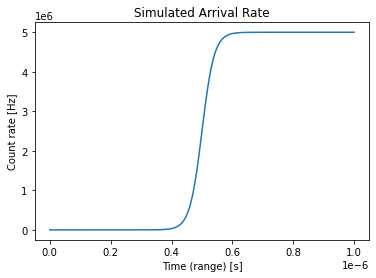

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_sim, photon_rate_arr)
ax.set_xlabel('Time (range) [s]')
ax.set_ylabel('Count rate [Hz]')
ax.set_title('Simulated Arrival Rate')
plt.show()

In [58]:
# generate photon counts

# lists of photon arrivals per
# laser shot
t_det_lst = []  # detected photons (includes deadtime)
t_phot_lst = [] # actual photons (no dead time)

t_det_last = -100.0  # last photon detection event
for n in range(Nshot):
    # simulate a laser shot
    ptime,ctime = sim.photon_count_generator(t_sim_bins, 
                                            photon_rate_arr, 
                                            tau_d_flt=tD,
                                            last_photon_flt=t_det_last)
    if wrap_deadtime:
        if len(ctime) > 0:
            t_det_last = ctime[-1]
        t_det_last -= t_sim_bins[-1]
        
    t_det_lst += [ctime]  # detection time tags (including deadtime)
    t_phot_lst += [ptime] # photon time tags

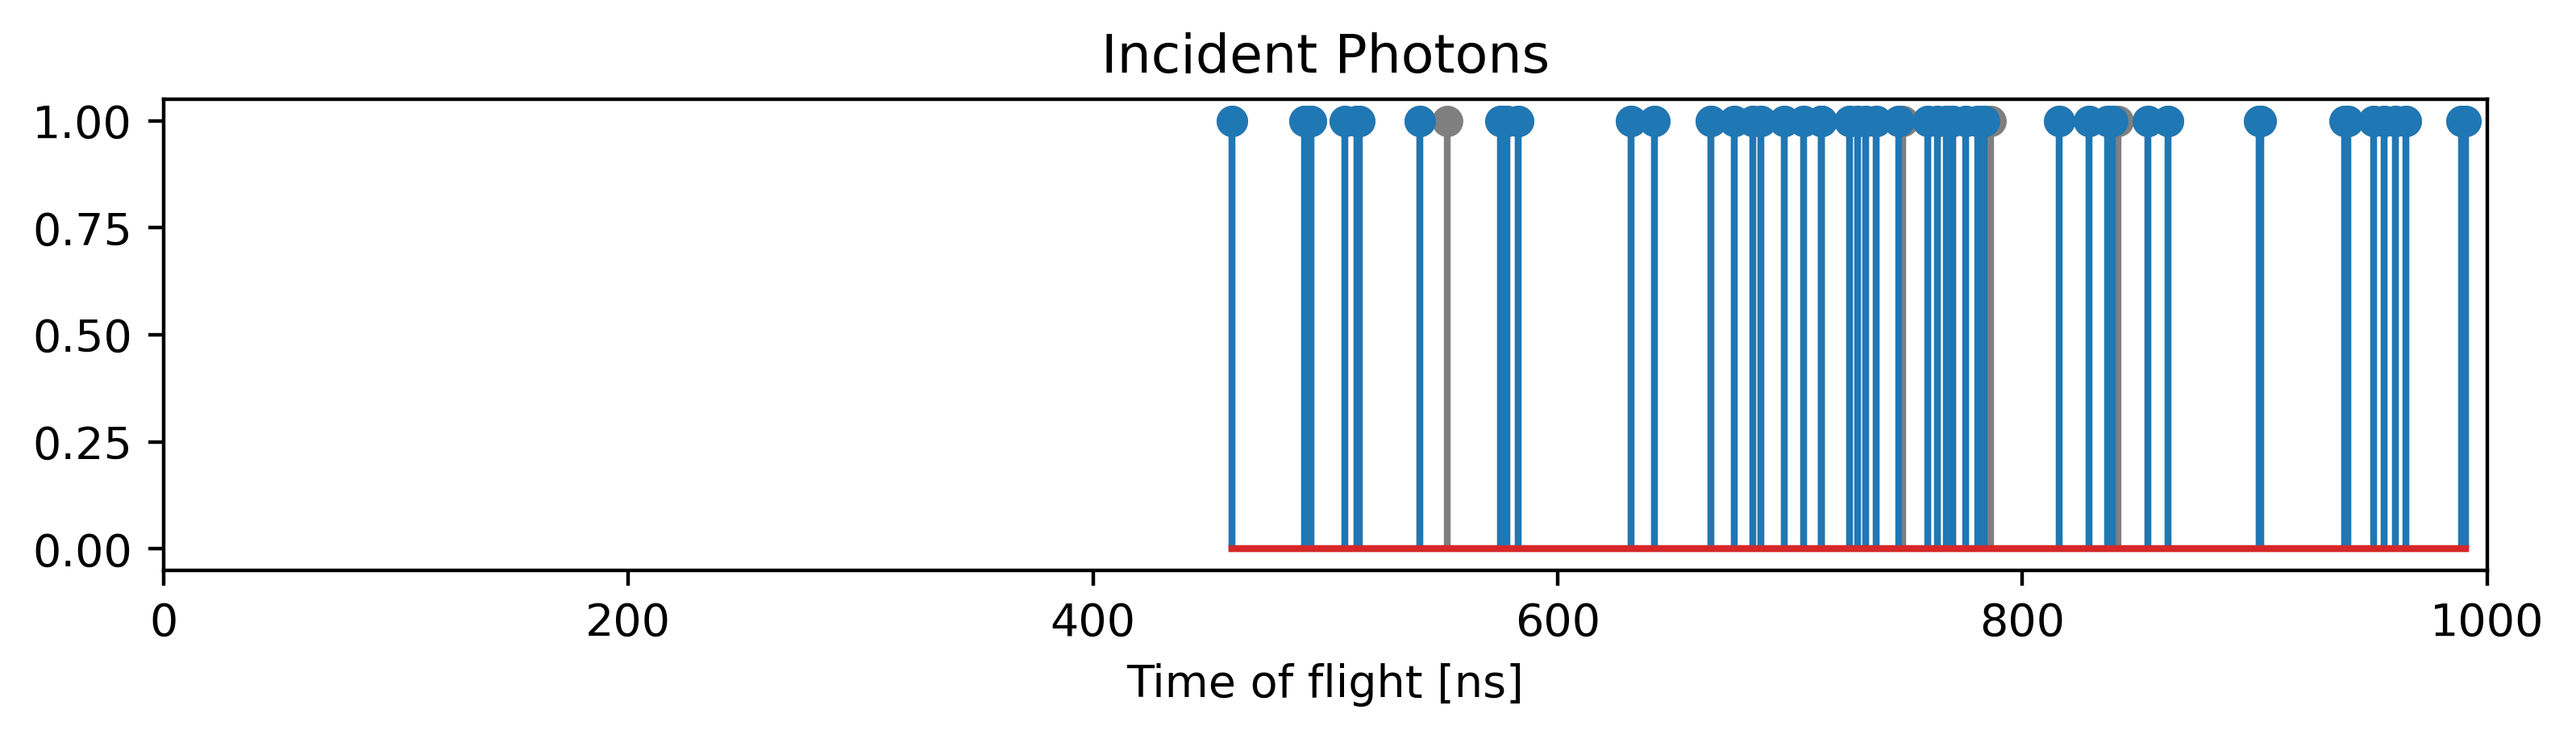

In [59]:
phot_arr = np.array(sorted(np.concatenate(t_phot_lst)))
cnt_arr = np.array(sorted(np.concatenate(t_det_lst)))

fig = plt.figure(figsize=(8, 4), dpi=400)
ax1 = fig.add_subplot(211)
ax1.stem(phot_arr*1e9, np.ones(phot_arr.size), markerfmt='C7o', linefmt='C7o', label='Undetected Photons')
ax1.stem(cnt_arr*1e9, np.ones(cnt_arr.size), markerfmt='C0o', linefmt='C0o', label='Detected Photons')
ax1.set_title('Incident Photons')
ax1.set_xlabel('Time of flight [ns]')
ax1.set_xlim([t_sim_min*1e9, t_sim_max*1e9])

plt.tight_layout()
plt.show()

In [60]:
# split data into fit and validation sets
# since we are assuming a fixed target between shots
# we can just split the data in chunks.
split_index = int(len(t_phot_lst)//2)
cnt_phot_fit = len(t_phot_lst[:split_index])
cnt_phot_val = len(t_phot_lst[split_index:])
t_phot_fit = np.concatenate(t_phot_lst[:split_index])
t_phot_val = np.concatenate(t_phot_lst[split_index:])

In [79]:
# integral_est = A/B*np.log(np.exp(B*t_sim)+np.exp(B*C))+D*t_sim
integral_est = A/B*np.log(np.exp(B*(C-t_sim))+1)+t_sim*(A+D)

# integral_est = torch.tensor(t_sim*background) \
#         + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi) \
#         + 0.5*target_amplitude*laser_pulse_width*np.sqrt(2*np.pi)\
#             *torch.special.erf((t_torch-target_time)/(laser_pulse_width*np.sqrt(2)))

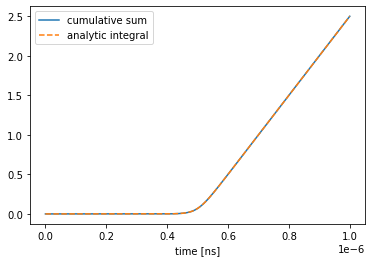

In [82]:
plt.figure()
plt.plot(t_sim, np.cumsum(photon_rate_arr)*dt_sim, label='cumulative sum')
plt.plot(t_sim, integral_est-2.5, '--', label='analytic integral')
plt.xlabel('time [ns]')
plt.legend()
plt.show()